In [1]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os
from pathlib import Path

## numbers for traininng

In [30]:
estimated_image_count = 600 #TODO count it
batch_size=32
nr_samples = estimated_image_count
nr_epochs = 10 #TODO way more or early stop (see at training above)
steps_per_epoch =  nr_samples / batch_size

# load data 

In [19]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
    vertical_flip=True
)

train_dir = "./images/cleaned"
IMG_HEIGHT, IMG_WIDTH = 128, 128

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))



print(train_data_gen.class_indices)

Found 543 images belonging to 4 classes.
{'Bier': 0, 'Cocktail': 1, 'Wasser': 2, 'Wein': 3}


# display images

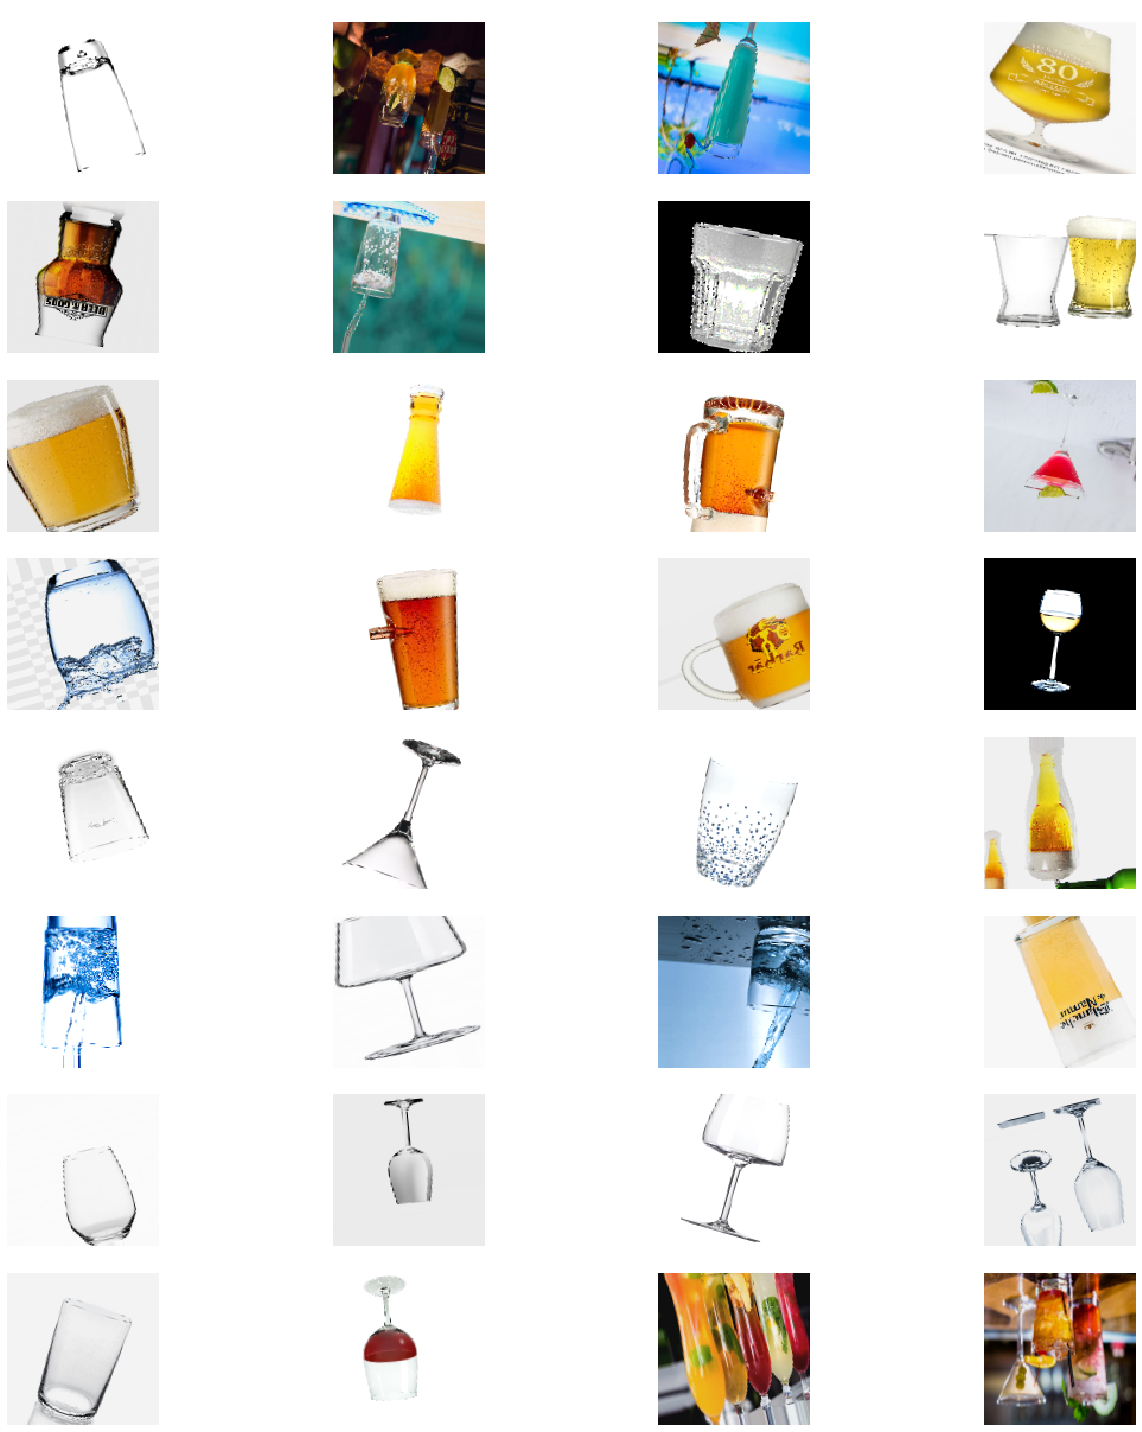

In [23]:
sample_training_images, labels = next(train_data_gen)
class_label = {v:k for k,v in train_data_gen.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

# model

In [37]:
# base_model = tf.keras.applications.resnet_v2.ResNet50V2(
#         include_top=False,
#         pooling='max',
#         input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
#         weights='imagenet')

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, kernel_initializer='lecun_normal', activation='selu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(train_data_gen.num_classes, 'softmax')
])
    
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
average_pooling2d (AveragePo (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 16384)           

### utility function that will skip batches if there is a broken image in it

In [8]:
def skip_broken_images(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except GeneratorExit:
            break
        except:
            pass

# train fully connected layers

al_accuracy: 0.7781C:\Users\Michael\Anaconda3\envs\akt\lib\site-packages\PIL\Image.py:2817: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
13/18 [===================>..........] - ETA: 18s - loss: 0.5976 - categorical_accuracy: 0.7687C:\Users\Michael\Anaconda3\envs\akt\lib\site-packages\PIL\Image.py:2817: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
14/18 [=====================>........] - ETA: 18s - loss: 0.6174 - categorical_accuracy: 0.7696C:\Users\Michael\Anaconda3\envs\akt\lib\site-packages\PIL\Image.py:2817: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
15/18 [=======================>......] - ETA: 14s - loss: 0.6105 - categorical_accuracy: 0.7683C:\Users\Michael\Anaconda3\envs\akt\lib\site-packages\PIL\Image.py:2817: UserWarning: image file could not be identified because WEBP support not install

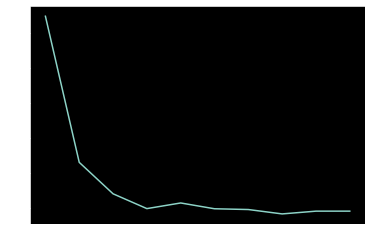

In [35]:
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

history = model.fit_generator(
    skip_broken_images(train_data_gen),
    steps_per_epoch=steps_per_epoch, #use way more steps here: number of samples / batch size
    epochs=nr_epochs,# or EarlyStopping callback
    callbacks=[]
)

plt.plot(history.history['loss'])

# train complete network

In [30]:
for layer in base_model.layers:
    layer.trainable = True
    
    
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])    

history = model.fit_generator(
    skip_broken_images(train_data_gen),
    steps_per_epoch=steps_per_epoch, #use way more steps here: number of samples / batch size
    epochs=nr_epochs # or EarlyStopping callback
    callbacks=[]
)

plt.plot(history.history['loss'])

KeyboardInterrupt: 

# save model

In [36]:
model.save('drink-detection.h5')